In [7]:
import jax, numpyro
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.distributions import (
    Normal, Uniform, TruncatedNormal, Beta, ImproperUniform, InverseGamma, StudentT
)
from corner import corner

from eggman.emulator import Emulator
from eggman.distributions import Salpeter

numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)
rng = random.PRNGKey(0)

In [2]:
emulator = Emulator()

In [3]:
log_zx_sun = np.log10(0.0181)
log_teff_sun = np.log10(5772)

In [4]:
bounds = jnp.arange(0.0, 5.0)
widths = jnp.diff(bounds)
new_bounds = jnp.array([0.0, 0.3, 0.6, 0.7, 1.0])
new_widths = jnp.diff(new_bounds)

def generator(a, b, c):
    return lambda x: a + b * (x - c)

funclist = [generator(l, w/nw, nl) for w, nw, l, nl in zip(widths, new_widths, bounds[:-1], new_bounds[:-1])]
    
def evol_phase(x):
    return jnp.piecewise(
        x,
        [(lower <= x) & (x < upper) for lower, upper in zip(new_bounds[:-1], new_bounds[1:])],
        funclist,
    )

(0.0, 4.0)

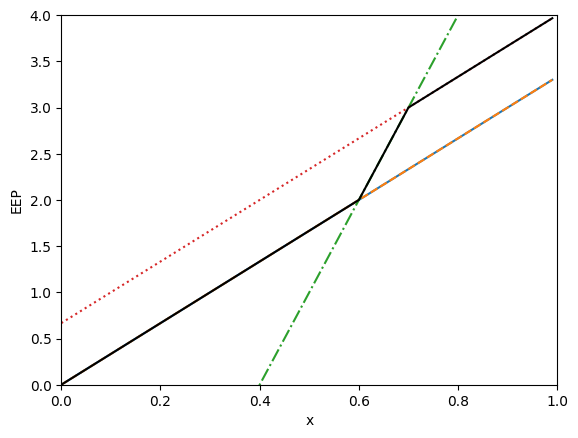

In [5]:
x = np.arange(0, 1, 0.01)

for ls, f in zip(['solid', 'dashed', 'dashdot', 'dotted'], funclist):
    plt.plot(x, f(x), ls=ls)
y = evol_phase(x)

plt.plot(x, y, "k")
plt.xlabel("x")
plt.ylabel("EEP")
plt.xlim(0, 1)
plt.ylim(0, 4)

In [64]:
def log_luminosity(log_teff, log_radius):
    return 2 * log_radius + 4 * (log_teff - log_teff_sun)

def hydrogen(y, z):
    return 1 - y - z

def metallicity(y, z):    
    return jnp.log10(z / hydrogen(y, z)) - log_zx_sun

def heavy_elements(y, mh):
    return (1 - y) / (10**-(mh + log_zx_sun) + 1)

def model(lum_obs=None, teff_obs=None, mh_obs=None, sigma_lum=0.01, sigma_teff=50.0, sigma_mh=0.05):    
    x = numpyro.sample("x", Uniform(0.0, 0.999))
    eep = numpyro.deterministic("EEP", evol_phase(x))
    
    mass = numpyro.sample("mass", Salpeter(2.35, low=0.7, high=2.3))
    y = numpyro.sample("Y", Uniform(0.22, 0.32))
    
    if mh_obs is None:
        mh = numpyro.sample("M_H", Uniform(-0.9, 0.5))
    else:
        mh = numpyro.sample("M_H", TruncatedNormal(mh_obs, sigma_mh, low=-0.9, high=0.5))

    z = numpyro.deterministic("Z", heavy_elements(y, mh))
    log_z = numpyro.deterministic("log_Z", jnp.log10(z))

#     log_z = numpyro.sample("log_Z", Uniform(-2.8, -1.4))
#     z = numpyro.deterministic("Z", 10**log_z)
    
    a_mlt = numpyro.sample("a_MLT", Uniform(1.3, 2.7))

    xx = jnp.stack([eep, mass, y, log_z, a_mlt], axis=-1)
    yy = emulator(xx)

    log_lum = log_luminosity(yy[1], yy[2])
    
    lum = numpyro.deterministic("lum", 10**log_lum)
    teff = numpyro.deterministic("Teff", 10**yy[1])
    
    numpyro.sample("lum_obs", StudentT(10, lum, sigma_lum), obs=lum_obs)
    numpyro.sample("Teff_obs", StudentT(10, teff, sigma_teff), obs=teff_obs)
#     numpyro.sample("M_H", TruncatedNormal(metallicity(y, z), sigma_mh, low=-0.9, high=0.5), obs=mh)

    log_age = numpyro.deterministic("log_age", yy[0])
    age = numpyro.deterministic("age", 10**log_age)

    # While this validate_args sets log_prob to -inf if outside bounds
    # This counts as a divergence. Not ideal! 
#     numpyro.factor("log_prob_age", Uniform(1e7, 14e9, validate_args=True).log_prob(age))

In [65]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=10000)
prior_samples = prior_predictive(key)

In [97]:
data = az.from_numpyro(prior=prior_samples)
data

Inference data with groups:
	> prior

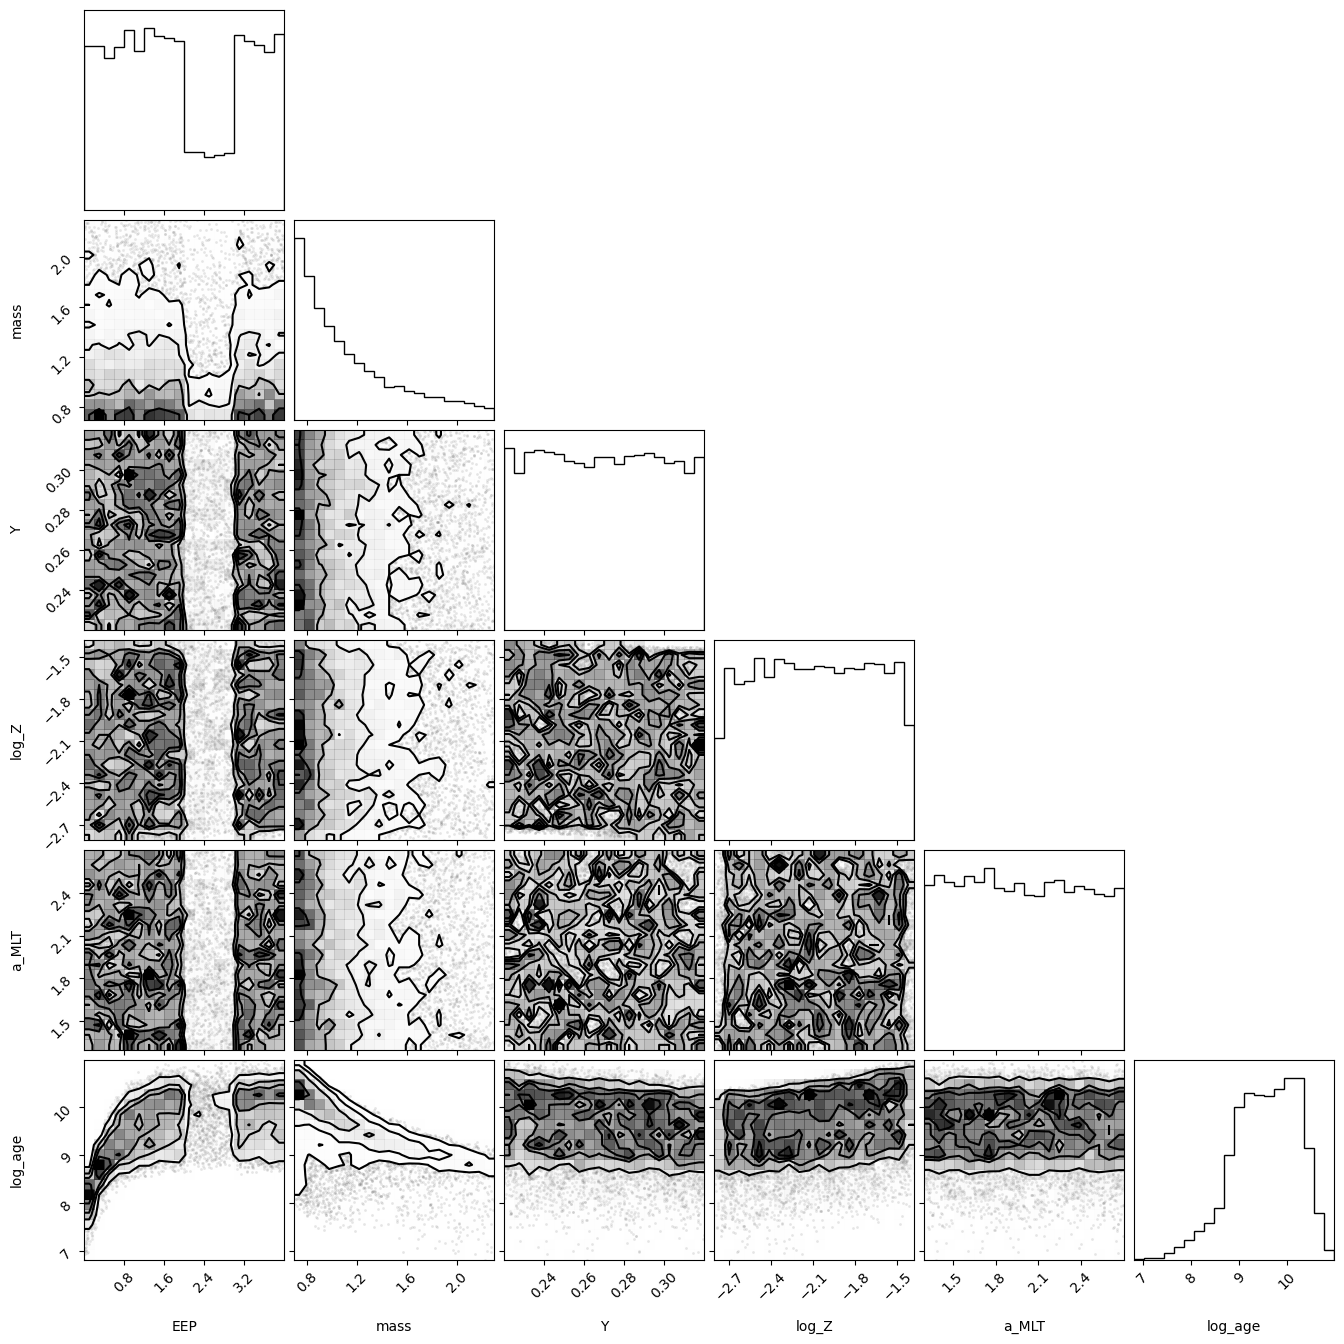

In [67]:
fig = corner(data, group="prior", var_names=["EEP", "mass", "Y", "log_Z", "a_MLT", "log_age"])

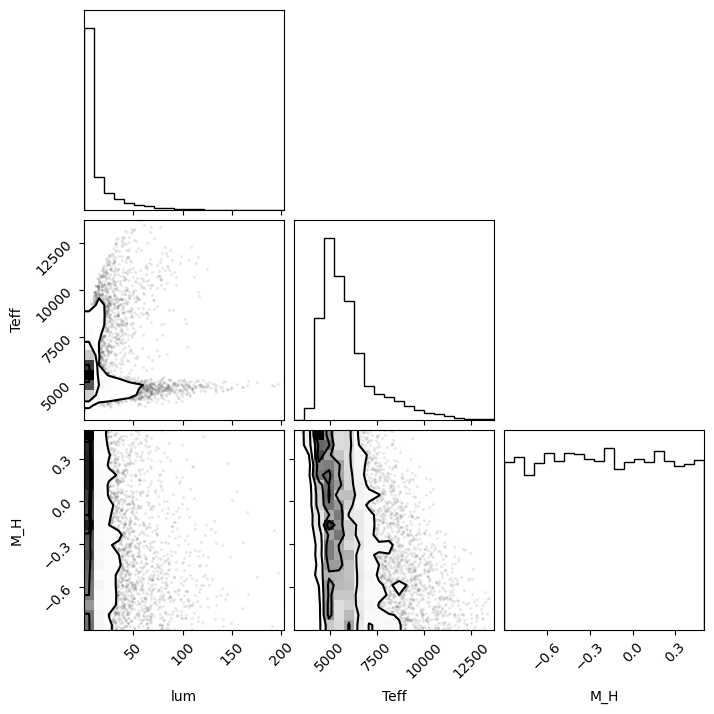

In [68]:
fig = corner(data, group="prior", var_names=["lum", "Teff", "M_H"])

In [86]:
data.prior.sel(draw=0)

<xarray.Dataset>
Dimensions:   (chain: 1)
Coordinates:
  * chain     (chain) int64 0
    draw      int64 0
Data variables: (12/14)
    EEP       (chain) float64 1.468
    M_H       (chain) float64 -0.5641
    Teff      (chain) float64 6.393e+03
    Teff_obs  (chain) float64 6.328e+03
    Y         (chain) float64 0.292
    Z         (chain) float64 0.003479
    ...        ...
    log_Z     (chain) float64 -2.459
    log_age   (chain) float64 9.731
    lum       (chain) float64 2.544
    lum_obs   (chain) float64 2.54
    mass      (chain) float64 0.9306
    x         (chain) float64 0.4404
Attributes:
    created_at:                 2023-08-17T13:06:03.521646
    arviz_version:              0.15.1
    inference_library:          numpyro
    inference_library_version:  0.12.1

In [87]:
lum, sigma_lum = 2.54, 0.08
teff, sigma_teff = 6393.0, 50.
mh, sigma_mh = -0.56, 0.1
# mh = None

# lum, sigma_lum = 1.0, 0.03
# teff, sigma_teff = 5772.0, 75.
# mh, sigma_mh = 0.0, 0.1

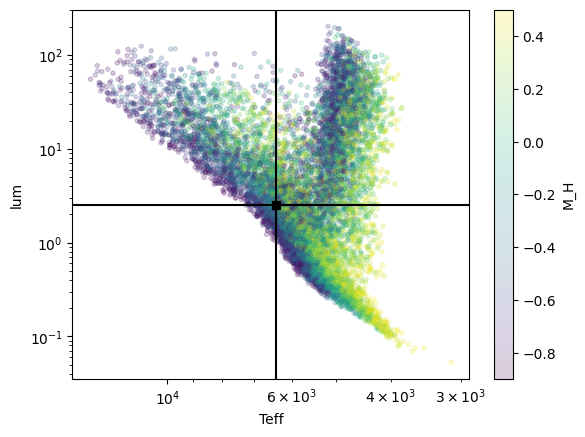

In [88]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "M_H"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

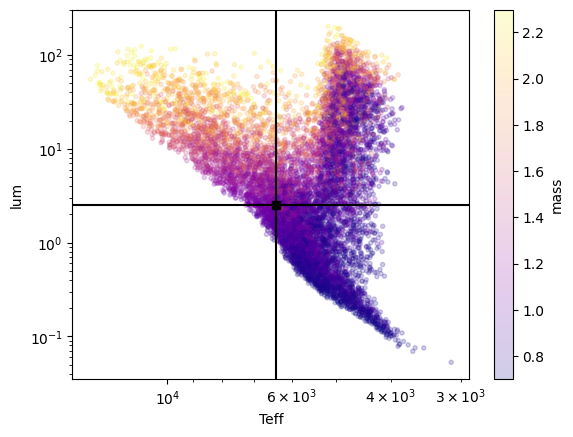

In [89]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "mass"
cmap = "plasma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

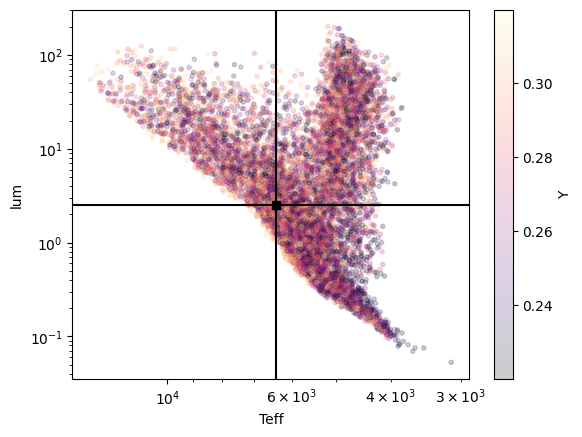

In [90]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "Y"
cmap = "magma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

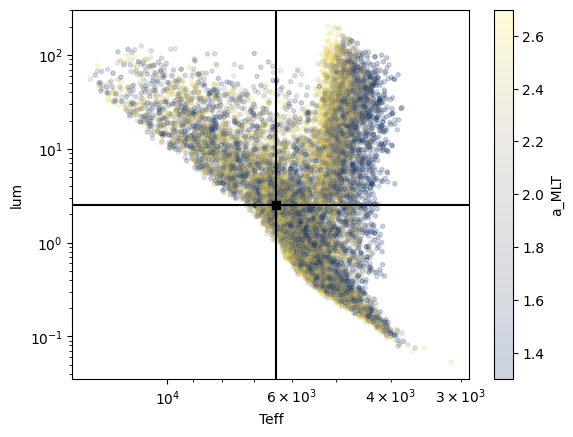

In [91]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "a_MLT"
cmap = "cividis"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

In [92]:
nuts = NUTS(model, init_strategy=numpyro.infer.init_to_median,
#             dense_mass=[("M_H", "a_MLT")],  # huge degenerecy between these
#             dense_mass=True  # helps a lot
            )
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=10)

It is very important that luminosity uncertainty is reasonable. If too low, struggles to sample. This could be emulator noise.

In [93]:
rng, key = random.split(rng)
mcmc.run(key, lum_obs=lum, teff_obs=teff, mh_obs=mh,
         sigma_lum=sigma_lum, sigma_teff=sigma_teff, sigma_mh=sigma_mh)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [94]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       M_H     -0.55      0.10     -0.55     -0.71     -0.39   4720.14      1.00
         Y      0.27      0.03      0.27      0.22      0.31   3443.89      1.00
     a_MLT      2.01      0.40      2.01      1.41      2.66   3617.83      1.00
      mass      0.95      0.07      0.95      0.83      1.07   2657.02      1.00
         x      0.45      0.06      0.45      0.36      0.55   2619.88      1.00

Number of divergences: 0


In [98]:
data += az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

In [99]:
rng, key = random.split(rng)
post_predictive = Predictive(model, posterior_samples=mcmc.get_samples())
post_samples = post_predictive(key, mh_obs=mh, sigma_mh=sigma_mh)

In [100]:
data += az.from_numpyro(posterior_predictive=post_samples)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

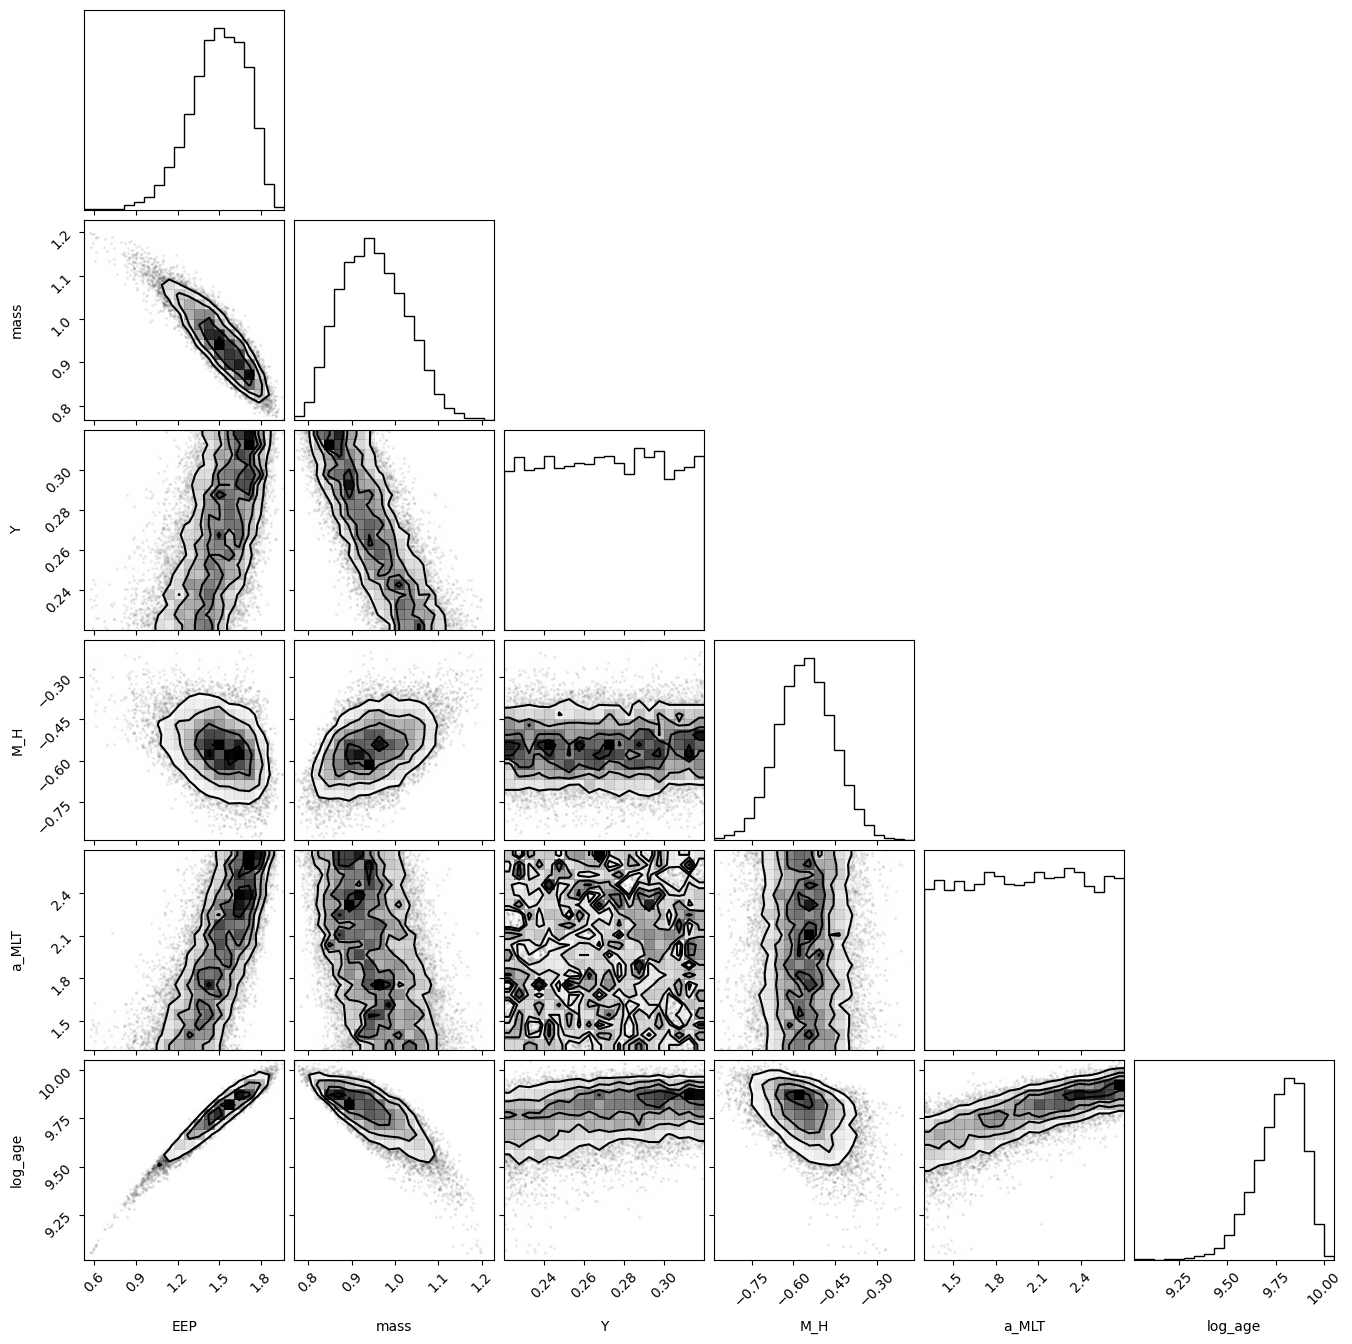

In [101]:
var_names = [
    "EEP", 
    "mass", 
    "Y", 
    "M_H", 
    "a_MLT", 
    "log_age",
]
fig = corner(
    data, 
    var_names=var_names, 
    divergences=True
)

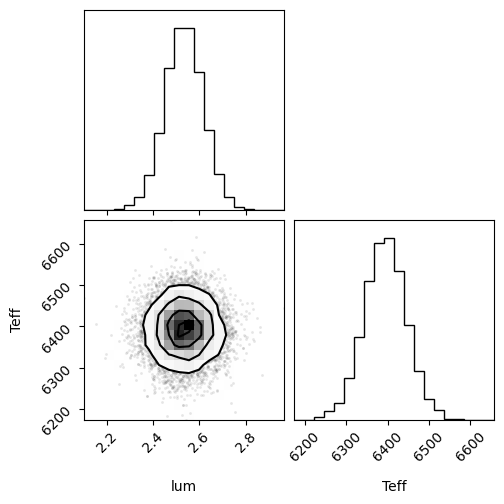

In [102]:
fig = corner(data, group="posterior", var_names=["lum", "Teff"])

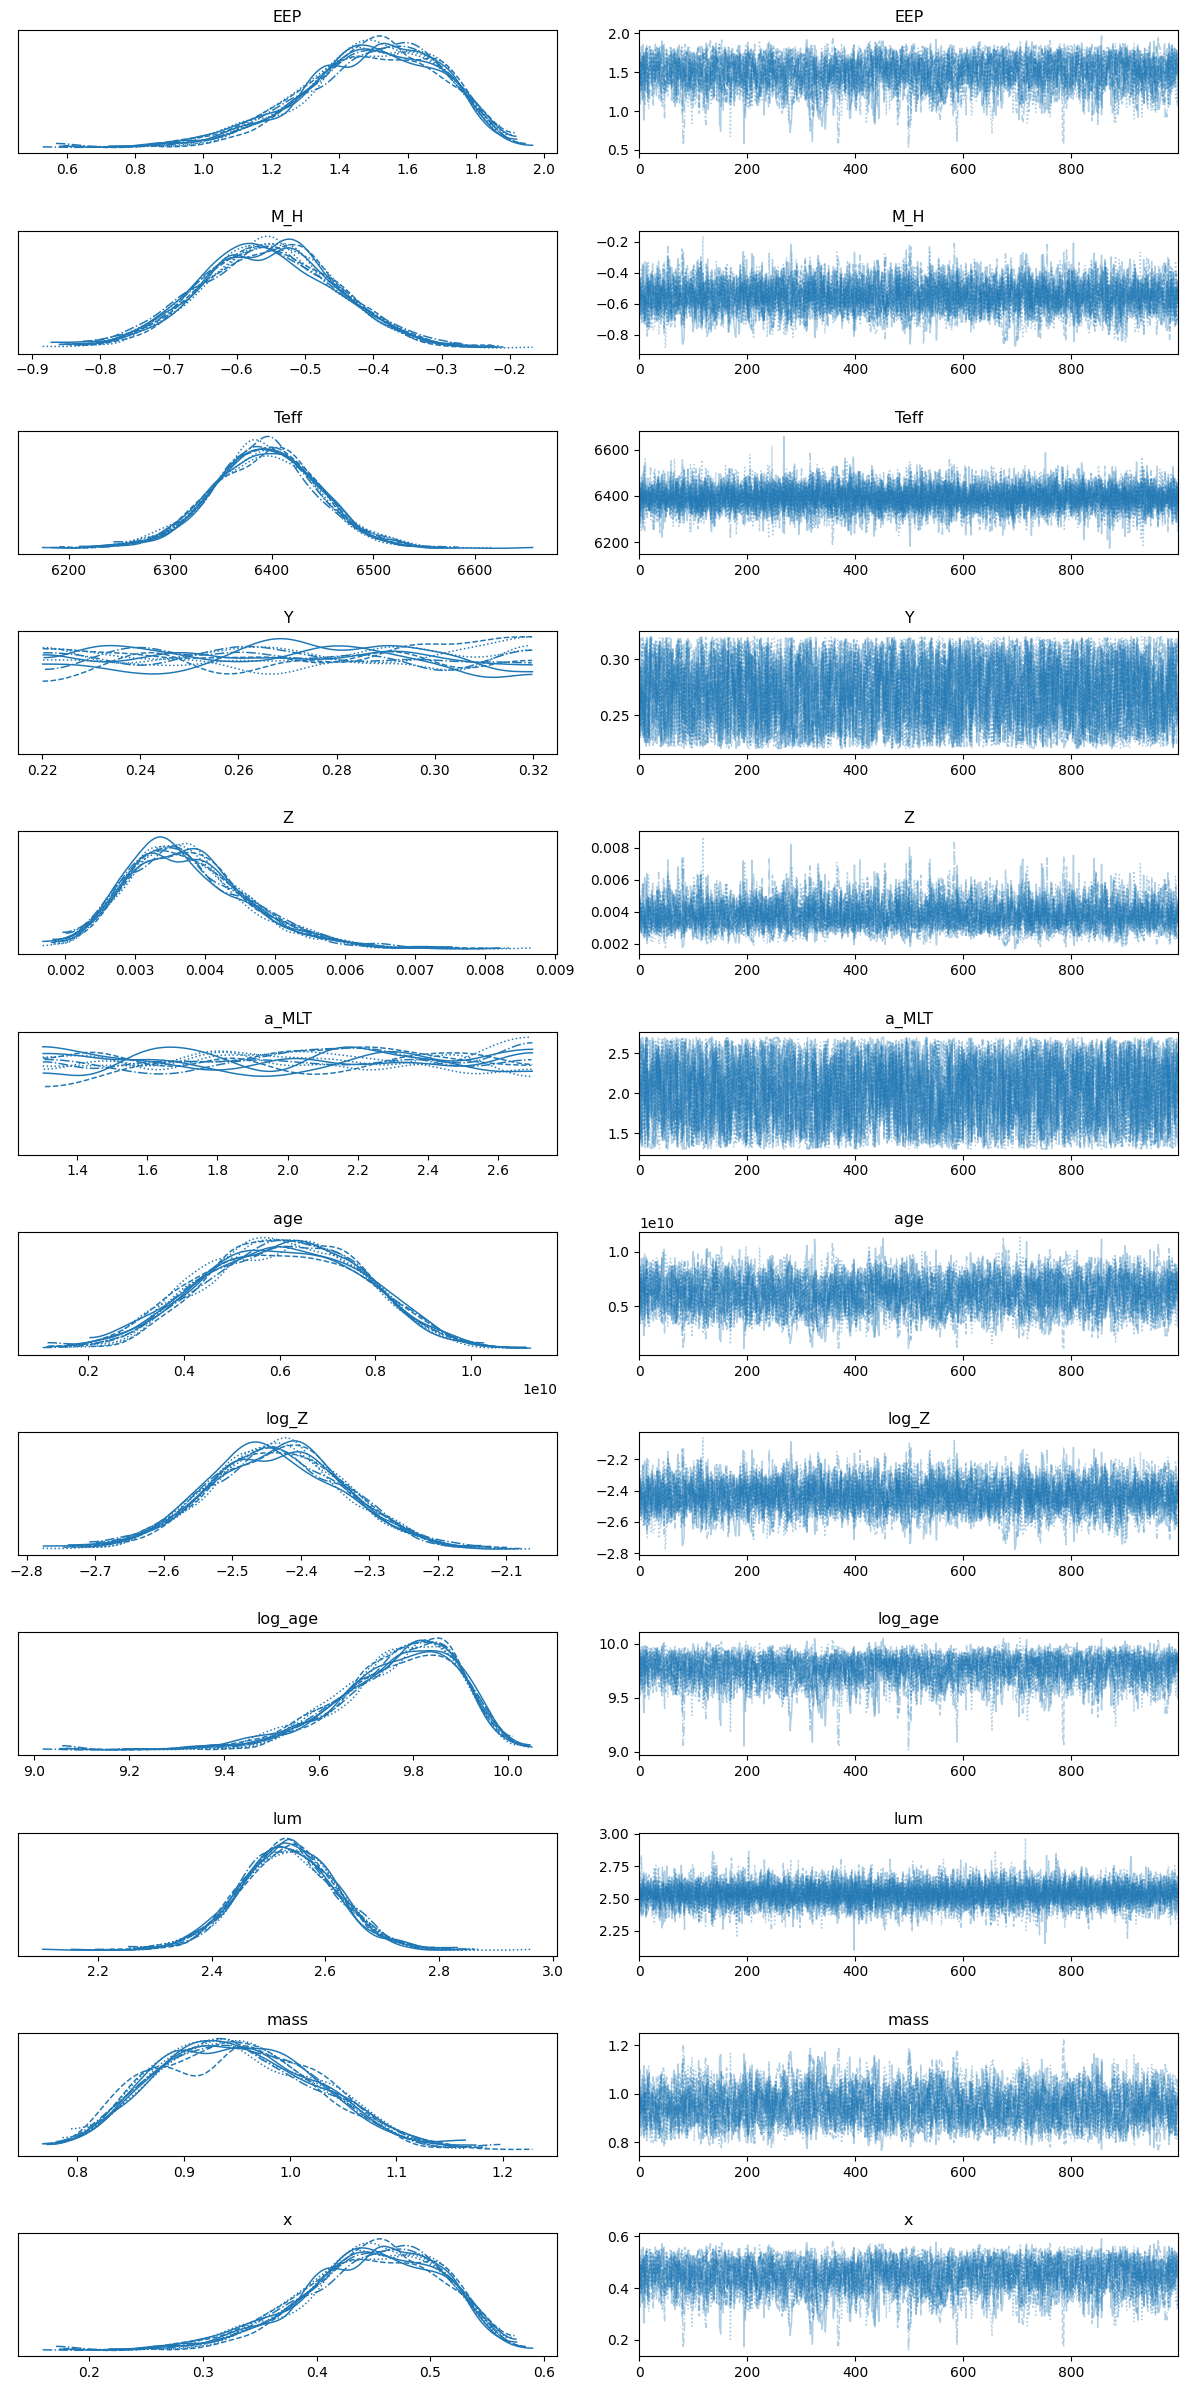

In [104]:
az.plot_trace(data)
plt.tight_layout()